# Tomato Leaf Disease Detection: ML vs DL Comparison
## 1. Environment Setup

In [3]:
# 1. Environment Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm # Progress bar
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.feature import hog
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.utils import class_weight
import numpy as np

## 2. Dataset Configuration


Detected classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Total number of classes: 10
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images
Total images in dataset: 16012


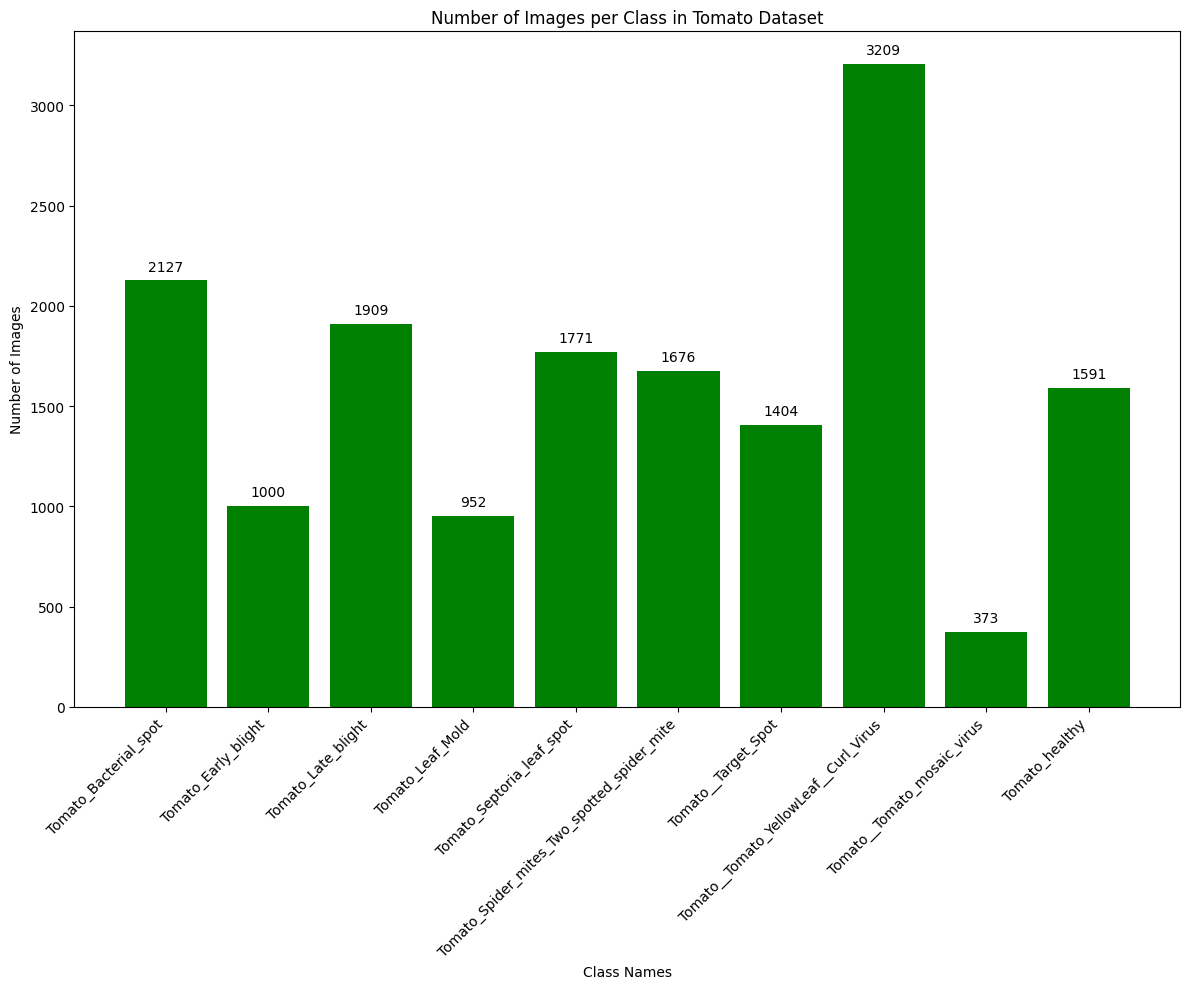

In [4]:
# Update paths to match your Colab directory structure
base_dir = ''
dataset_dir = os.path.join(base_dir, 'dataset')

# Get class names from directory structure
class_names = sorted([d for d in os.listdir(dataset_dir)])
print(f"Detected classes: {class_names}")
print(f"Total number of classes: {len(class_names)}")

# Check the total number of images in the dataset
total_images = 0
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"Class '{class_name}': {num_images} images")
    total_images += num_images
print(f"Total images in dataset: {total_images}")

# Initialize lists and counters to store image counts per class and total images
class_image_counts = []
total_images = 0

# Count the number of images in each class directory
for class_name in class_names:
    class_dir = dataset_dir + '/' + class_name
    num_images = len(os.listdir(class_dir))
    class_image_counts.append(num_images)
    total_images += num_images

# Plot a bar chart showing the number of images per class
fig, ax = plt.subplots(figsize=(12, 10))
bars = ax.bar(class_names, class_image_counts, color='green')
ax.bar_label(bars, padding=5)

# Customize x-axis labels
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")

# Set axis labels and chart title
ax.set_xlabel('Class Names')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images per Class in Tomato Dataset')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

## 3. Data Loading & Preprocessing

### Background Removal

In [10]:
def background_removal(img):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert the image from RGB to HSV color space
    hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

    # Define HSV ranges for green, yellow, and brown (common background colors)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([85, 255, 255])
    lower_yellow = np.array([15, 40, 40])
    upper_yellow = np.array([35, 255, 255])
    lower_brown = np.array([5, 50, 50])
    upper_brown = np.array([25, 255, 200])

    # Create masks for each color range
    green_mask = cv2.inRange(hsv, lower_green, upper_green)
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    brown_mask = cv2.inRange(hsv, lower_brown, upper_brown)

    # Combine all color masks into one
    mask = cv2.bitwise_or(green_mask, yellow_mask)
    mask = cv2.bitwise_or(mask, brown_mask)

    # Apply morphological operations to clean the mask (remove noise and fill gaps)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Extract the largest contour (likely the main object) if any significant ones exist
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        new_mask = np.zeros_like(mask)
        cv2.drawContours(new_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
        mask = new_mask



    # Apply the final mask to the original image
    segmented = cv2.bitwise_and(img, img, mask=mask)
    return mask, segmented

### Test a Random Image

### Exporting the Image

In [11]:
# Define base directories for input (original images) and output (background-removed images)
input_base = "./dataset/"
output_base = "./tomato_bg_removed/"

In [12]:
import cv2
# Create the output base directory if it doesn't already exist
os.makedirs(output_base, exist_ok=True)

# Process each subdirectory (class) inside the input directory
for folder in sorted(os.listdir(input_base)):
    input_folder = os.path.join(input_base, folder)
    output_folder = os.path.join(output_base, folder)

    # Skip if it's not a directory
    if not os.path.isdir(input_folder):
        continue

    # Create corresponding output folder
    os.makedirs(output_folder, exist_ok=True)

    # Get list of valid image files (up to 300 per class)
    image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff"))]
    image_files = sorted(image_files)[:4000]

    print(f"\n🔹 Processing folder: {folder} ({len(image_files)} images)")

    # Process each image in the folder
    for filename in tqdm(image_files, desc=f"{folder}", unit="img"):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        # Read the image
        img = cv2.imread(input_path)
        if img is None:
            print(f"❌ Failed to load image: {input_path}")
            continue

        # Convert image to RGB (OpenCV loads in BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply background removal
        _, segmented = background_removal(img_rgb)

        # Convert segmented image back to BGR for saving
        segmented_bgr = cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)

        # Save the output image
        cv2.imwrite(output_path, segmented_bgr)


🔹 Processing folder: Tomato_Bacterial_spot (2127 images)


Tomato_Bacterial_spot: 100%|█████████████████████████████████████████████████████| 2127/2127 [00:08<00:00, 265.41img/s]



🔹 Processing folder: Tomato_Early_blight (1000 images)


Tomato_Early_blight: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.24img/s]



🔹 Processing folder: Tomato_Late_blight (1909 images)


Tomato_Late_blight: 100%|████████████████████████████████████████████████████████| 1909/1909 [00:07<00:00, 266.83img/s]



🔹 Processing folder: Tomato_Leaf_Mold (952 images)


Tomato_Leaf_Mold: 100%|████████████████████████████████████████████████████████████| 952/952 [00:03<00:00, 274.64img/s]



🔹 Processing folder: Tomato_Septoria_leaf_spot (1771 images)


Tomato_Septoria_leaf_spot: 100%|█████████████████████████████████████████████████| 1771/1771 [00:06<00:00, 259.86img/s]



🔹 Processing folder: Tomato_Spider_mites_Two_spotted_spider_mite (1676 images)


Tomato_Spider_mites_Two_spotted_spider_mite: 100%|███████████████████████████████| 1676/1676 [00:06<00:00, 245.60img/s]



🔹 Processing folder: Tomato__Target_Spot (1404 images)


Tomato__Target_Spot: 100%|███████████████████████████████████████████████████████| 1404/1404 [00:05<00:00, 247.43img/s]



🔹 Processing folder: Tomato__Tomato_YellowLeaf__Curl_Virus (3208 images)


Tomato__Tomato_YellowLeaf__Curl_Virus: 100%|█████████████████████████████████████| 3208/3208 [00:11<00:00, 268.43img/s]



🔹 Processing folder: Tomato__Tomato_mosaic_virus (373 images)


Tomato__Tomato_mosaic_virus: 100%|█████████████████████████████████████████████████| 373/373 [00:01<00:00, 262.52img/s]



🔹 Processing folder: Tomato_healthy (1591 images)


Tomato_healthy: 100%|████████████████████████████████████████████████████████████| 1591/1591 [00:05<00:00, 274.54img/s]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.utils.class_weight import compute_class_weight

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enable mixed precision
set_global_policy('mixed_float16')

# Configure TensorFlow for CPU (12 threads)
tf.config.threading.set_intra_op_parallelism_threads(12)
tf.config.threading.set_inter_op_parallelism_threads(12)

# Global constants
batch_size = 16
TRAIN_PERCENT = 0.8
img_size = (128, 128)  # Increased for better detail
dataset_dir = "tomato_bg_removed"

# Get class names and count images
class_names = sorted([d for d in os.listdir(dataset_dir) 
                     if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.')])
print(f"Detected classes: {class_names}")
print(f"Total number of classes: {len(class_names)}")

total_images = 0
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    num_images = len([f for f in os.listdir(class_dir) 
                     if os.path.isfile(os.path.join(class_dir, f))])
    class_counts[class_name] = num_images
    print(f"Class '{class_name}': {num_images} images")
    total_images += num_images
print(f"Total images in dataset: {total_images}")

# Compute class weights
class_labels = [i for i, count in enumerate(class_counts.values()) for _ in range(count)]
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)))
print("Class weights:", class_weights)

def process_image(file_path, label, img_size=(128, 128)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_size)
    img.set_shape([img_size[0], img_size[1], 3])
    return img, label

# Data augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.0417),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal")
])

def create_dataset(dataset_dir, class_names, img_size=(128, 128), train_percent=0.8):
    file_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        file_paths.extend(files)
        labels.extend([class_idx] * len(files))
        print(f"Processing class {class_name}... ({len(files)} images)")

    file_paths = tf.constant(file_paths)
    labels = tf.constant(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.shuffle(buffer_size=len(file_paths), seed=42)
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    total_size = len(file_paths)
    train_size = int(train_percent * total_size)
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset

# Load datasets
train_dataset, test_dataset = create_dataset(dataset_dir, class_names, img_size)
print(f"Dataset loaded: ~{total_images} images, {img_size} resolution")
print(f"Training set: ~{int(total_images * TRAIN_PERCENT)} images")
print(f"Testing set: ~{total_images - int(total_images * TRAIN_PERCENT)} images")

def build_inceptionv3_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    base = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize model
model = build_inceptionv3_model()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_inceptionv3.h5', save_best_only=True)
]

# First training phase
print("Training InceptionV3 (frozen base)...")
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Fine-tuning phase
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-10]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Fine-tuning InceptionV3 (last 10 layers)...")
history_finetune = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Combine histories
history.history['accuracy'] += history_finetune.history['accuracy']
history.history['val_accuracy'] += history_finetune.history['val_accuracy']
history.history['loss'] += history_finetune.history['loss']
history.history['val_loss'] += history_finetune.history['val_loss']

# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.close()

# Confusion matrix
y_pred = []
y_true = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - InceptionV3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"InceptionV3 Test Accuracy (after fine-tuning): {test_acc:.4f}")
model.save('best_inceptionv3.h5')
print("InceptionV3 model saved as best_inceptionv3.h5")

Detected classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Total number of classes: 10
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3208 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images
Total images in dataset: 16011
Class weights: {0: np.float64(0.7527503526093089), 1: np.float64(1.6011), 2: np.float64(0.8387113672079622), 3: np.float64(1.681827731092437), 4: np.float64(0.9040654997176736), 5: np.fl

801/801 ━━━━━━━━━━━━━━━━━━━━ 216s 262ms/step - accuracy: 0.2696 - loss: 2.4496 - val_accuracy: 0.6026 - val_loss: 1.1888
Epoch 2/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5004 - loss: 1.5269

801/801 ━━━━━━━━━━━━━━━━━━━━ 204s 255ms/step - accuracy: 0.5004 - loss: 1.5269 - val_accuracy: 0.6741 - val_loss: 0.9787
Epoch 3/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5487 - loss: 1.3937

801/801 ━━━━━━━━━━━━━━━━━━━━ 213s 266ms/step - accuracy: 0.5487 - loss: 1.3937 - val_accuracy: 0.6968 - val_loss: 0.8974
Epoch 4/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5819 - loss: 1.2739

801/801 ━━━━━━━━━━━━━━━━━━━━ 211s 263ms/step - accuracy: 0.5819 - loss: 1.2739 - val_accuracy: 0.7068 - val_loss: 0.8744
Epoch 5/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5966 - loss: 1.2321

801/801 ━━━━━━━━━━━━━━━━━━━━ 215s 268ms/step - accuracy: 0.5966 - loss: 1.2321 - val_accuracy: 0.7284 - val_loss: 0.8026
Epoch 6/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6126 - loss: 1.1627

801/801 ━━━━━━━━━━━━━━━━━━━━ 208s 259ms/step - accuracy: 0.6126 - loss: 1.1627 - val_accuracy: 0.7299 - val_loss: 0.7878
Epoch 7/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6222 - loss: 1.1397

801/801 ━━━━━━━━━━━━━━━━━━━━ 208s 259ms/step - accuracy: 0.6222 - loss: 1.1397 - val_accuracy: 0.7459 - val_loss: 0.7615
Epoch 8/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 214s 266ms/step - accuracy: 0.6371 - loss: 1.1172 - val_accuracy: 0.7349 - val_loss: 0.7638
Epoch 9/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6361 - loss: 1.1135

801/801 ━━━━━━━━━━━━━━━━━━━━ 214s 266ms/step - accuracy: 0.6361 - loss: 1.1135 - val_accuracy: 0.7440 - val_loss: 0.7318
Epoch 10/10
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6496 - loss: 1.0670

801/801 ━━━━━━━━━━━━━━━━━━━━ 211s 263ms/step - accuracy: 0.6496 - loss: 1.0670 - val_accuracy: 0.7574 - val_loss: 0.7126
Fine-tuning InceptionV3 (last 10 layers)...
Epoch 1/3
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6550 - loss: 1.0386

801/801 ━━━━━━━━━━━━━━━━━━━━ 206s 248ms/step - accuracy: 0.6550 - loss: 1.0386 - val_accuracy: 0.7646 - val_loss: 0.7075
Epoch 2/3
801/801 ━━━━━━━━━━━━━━━━━━━━ 194s 242ms/step - accuracy: 0.6586 - loss: 1.0294 - val_accuracy: 0.7499 - val_loss: 0.7397
Epoch 3/3
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6679 - loss: 1.0184

801/801 ━━━━━━━━━━━━━━━━━━━━ 197s 246ms/step - accuracy: 0.6679 - loss: 1.0184 - val_accuracy: 0.7627 - val_loss: 0.7012


InceptionV3 Test Accuracy (after fine-tuning): 0.7562
InceptionV3 model saved as best_inceptionv3.h5


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.utils.class_weight import compute_class_weight

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enable mixed precision
set_global_policy('mixed_float16')

# Configure TensorFlow for CPU (12 threads)
tf.config.threading.set_intra_op_parallelism_threads(12)
tf.config.threading.set_inter_op_parallelism_threads(12)

# Global constants
batch_size = 16
TRAIN_PERCENT = 0.8
img_size = (128, 128)  # Increased for better detail
dataset_dir = "dataset"

# Get class names and count images
class_names = sorted([d for d in os.listdir(dataset_dir) 
                     if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.')])
print(f"Detected classes: {class_names}")
print(f"Total number of classes: {len(class_names)}")

total_images = 0
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    num_images = len([f for f in os.listdir(class_dir) 
                     if os.path.isfile(os.path.join(class_dir, f))])
    class_counts[class_name] = num_images
    print(f"Class '{class_name}': {num_images} images")
    total_images += num_images
print(f"Total images in dataset: {total_images}")

# Compute class weights
class_labels = [i for i, count in enumerate(class_counts.values()) for _ in range(count)]
class_weights = dict(enumerate(compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)))
print("Class weights:", class_weights)

def process_image(file_path, label, img_size=(128, 128)):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_size)
    img.set_shape([img_size[0], img_size[1], 3])
    return img, label

# Data augmentation
augmentation = models.Sequential([
    layers.RandomRotation(0.0417),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal")
])

def create_dataset(dataset_dir, class_names, img_size=(128, 128), train_percent=0.8):
    file_paths = []
    labels = []
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        file_paths.extend(files)
        labels.extend([class_idx] * len(files))
        print(f"Processing class {class_name}... ({len(files)} images)")

    file_paths = tf.constant(file_paths)
    labels = tf.constant(labels)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.shuffle(buffer_size=len(file_paths), seed=42)
    dataset = dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

    total_size = len(file_paths)
    train_size = int(train_percent * total_size)
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)

    train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y), 
                                     num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset

# Load datasets
train_dataset, test_dataset = create_dataset(dataset_dir, class_names, img_size)
print(f"Dataset loaded: ~{total_images} images, {img_size} resolution")
print(f"Training set: ~{int(total_images * TRAIN_PERCENT)} images")
print(f"Testing set: ~{total_images - int(total_images * TRAIN_PERCENT)} images")

def build_inceptionv3_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    base = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = False
    
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize model
model = build_inceptionv3_model()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_inceptionv3.h5', save_best_only=True)
]

# First training phase
print("Training InceptionV3 (frozen base)...")
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Fine-tuning phase
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-10]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Fine-tuning InceptionV3 (last 10 layers)...")
history_finetune = model.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Combine histories
history.history['accuracy'] += history_finetune.history['accuracy']
history.history['val_accuracy'] += history_finetune.history['val_accuracy']
history.history['loss'] += history_finetune.history['loss']
history.history['val_loss'] += history_finetune.history['val_loss']

# Plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.close()

# Confusion matrix
y_pred = []
y_true = []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - InceptionV3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"InceptionV3 Test Accuracy (after fine-tuning): {test_acc:.4f}")
model.save('best_inceptionv3.h5')
print("InceptionV3 model saved as best_inceptionv3.h5")

Detected classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Total number of classes: 10
Class 'Tomato_Bacterial_spot': 2127 images
Class 'Tomato_Early_blight': 1000 images
Class 'Tomato_Late_blight': 1909 images
Class 'Tomato_Leaf_Mold': 952 images
Class 'Tomato_Septoria_leaf_spot': 1771 images
Class 'Tomato_Spider_mites_Two_spotted_spider_mite': 1676 images
Class 'Tomato__Target_Spot': 1404 images
Class 'Tomato__Tomato_YellowLeaf__Curl_Virus': 3209 images
Class 'Tomato__Tomato_mosaic_virus': 373 images
Class 'Tomato_healthy': 1591 images
Total images in dataset: 16012
Class weights: {0: np.float64(0.752797367183827), 1: np.float64(1.6012), 2: np.float64(0.8387637506547931), 3: np.float64(1.6819327731092437), 4: np.float64(0.9041219649915302), 5: np.fl

KeyboardInterrupt: 